In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, FunctionTransformer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from warnings import warn
from itertools import combinations
import scipy
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import word2vec
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import keras

for p in [np, pd, sklearn, xgboost, scipy, keras]:
    print (p.__name__, p.__version__)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


numpy 1.14.6
pandas 0.22.0
sklearn 0.20.3
xgboost 0.7.post4
scipy 1.1.0
keras 2.2.4




# Introduction:

Schools can be a complex place. You have different kids, from different backgrounds; teachers, who have different teaching approaches and different resource needs; administrators and regulators, with a variety of methodologies to make the whole machine run smoothly - it can be a lot to manage. Thats were ERS comes in. They work hard to help schools optimize they way they manage their data driven processes. As a teacher, I have a strong interest in tackling this problem. My schools budget affects important components of my job - materials for science labs, computers for teaching programming, etc. - so seeing the opporunity to work on a data set that is focused on improving budget line management caught my attention.



---



In this notebook I will be building a machine learning model to automate the process of labeling school budget like items. The dataset comes from [DrivenData](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/) and was part of a machine learning competition that was recently rebooted. DrivenData worked with Education Resource Strategies (ERS) to develop this dataset and set up the problem/question I am addressing.

# Problem:

The problem is a supervised machine learning problem, specifically a multi-class, multi-label classification problem. The dataset is mostly composed of free-form text and some float columns, so there will be a great deal of preprocessing the text before input into the model. 

# Goal: 

My goal is to correctly label budget line items with 9 labels: Function, Use, Sharing, Reporting, Student_Type, Position_Type, Object_Type, Pre_K, Operating_Status. I expect to successfully develop a model that accurately classifies budget line items in a scalable manner. 

I want to focus on scalabilty alongside reducing the competitions performance metric (multilabel log loss). Since size is also something that makes this dataset challenging, I need to do my best to make my model as computationally efficient as possible - without sacrificing performance. 

I will most likely use a optimization based algorithm - e.g. stochastic gradient descent - to minimize the cost function. If possible, after getting a better sense of the data I want to try mini-batch gradient descent. 

# Methodology

The notebook will have the following sequence:

- Exploration: getting to the know the data.
- Preprocessing of the data: preparing the text for modeling.
- Building a pipeline to quickly experiment and test various models.
- Develop a baseline score: get a sense of the difficulty of the problem.
- Develop an approach: use various resources to create an ememble of models.


This notebook will be a walkthrough of the exploratory process that will eventually be fine tuned into several scripts for submission.




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


I needed to use google drive to import the large dataset into this notebook.

In [0]:
train = pd.read_csv("/content/drive/My Drive/TrainingData.csv", index_col=0) 
test = pd.read_csv("/content/drive/My Drive/TestData.csv", index_col=0)
submission = pd.read_csv("/content/drive/My Drive/SubmissionFormat.csv", index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [0]:
test.head()

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1
180042,Student Meals/Room/Other,Basic Educational Services,NaN,NaN,NaN,Line Item that is paid with Campus' money,School,NaN,Instruction,NaN,NaN,3999.910000,NaN,NaN,General Fund,NaN
28872,Extra Duty/Signing Bonus Pay,Undistributed,NaN,CHEERLEADER DIR,NaN,General,School,NaN,Cocurricular & Extra Curricular Activities,NaN,NaN,3447.320213,NaN,NaN,General Fund,NaN
186915,Professional Salaries,Bilingual Education,NaN,T-EL 1ST BIL,NaN,General,School,1.0,Instruction,NaN,NaN,52738.780869,NaN,NaN,General Fund,NaN
412396,Professional Salaries,Bilingual Education,NaN,T-EL 2ND BIL,NaN,General,School,1.0,Instruction,NaN,NaN,69729.263191,NaN,NaN,General Fund,NaN
427740,Salaries for Support Personnel,Undistributed,NaN,CLERK III- SCH,NaN,General,School,1.0,School Leadership,NaN,NaN,29492.834215,NaN,NaN,General Fund,NaN


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Data columns (total 16 columns):
Object_Description        48330 non-null object
Program_Description       44811 non-null object
SubFund_Description       16111 non-null object
Job_Title_Description     32317 non-null object
Facility_or_Department    2839 non-null object
Sub_Object_Description    33612 non-null object
Location_Description      37316 non-null object
FTE                       19605 non-null float64
Function_Description      46866 non-null object
Position_Extra            13813 non-null object
Text_4                    2814 non-null object
Total                     49404 non-null float64
Text_2                    4641 non-null object
Text_3                    5784 non-null object
Fund_Description          39586 non-null object
Text_1                    15378 non-null object
dtypes: float64(2), object(14)
memory usage: 6.5+ MB


The dataset has been split into a training and test set. The training set contains 400,277 samples and 25 features (9 of which are the target features). The test set has 50,064 samples and 16 features (no target features are included).


**FTE float** - If an employee, the percentage of full-time that the employee works.

**Facility_or_Department** - If expenditure is tied to a department/facility, that department/facility.

**Function_Description** - A description of the function the expenditure was serving.

**Fund_Description** - A description of the source of the funds.

**Job_Title_Description** - If this is an employee, a description of that employee's job title.

**Location_Description** - A description of where the funds were spent.

**Object_Description** - A description of what the funds were used for.

**Position_Extra** - Any extra information about the position that we have.

**Program_Description** - A description of the program that the funds were used for.

**SubFund_Description** - More detail on Fund_Description.

**Sub_Object_Description** - More detail on Object_Description.

**Text_1** - Any additional text supplied by the district.

**Text_2** - Any additional text supplied by the district.

**Text_3** - Any additional text supplied by the district.

**Text_4** - Any additional text supplied by the district.

**Total float** - The total cost of the expenditure.



# Exploration

In [0]:
# missing values
train.isnull().sum()/len(train)*100

Function                   0.000000
Use                        0.000000
Sharing                    0.000000
Reporting                  0.000000
Student_Type               0.000000
Position_Type              0.000000
Object_Type                0.000000
Pre_K                      0.000000
Operating_Status           0.000000
Object_Description         6.191712
Text_2                    77.961012
SubFund_Description       23.339338
Job_Title_Description     26.864896
Text_3                    72.730884
Text_4                    86.572798
Sub_Object_Description    77.115098
Location_Description      59.514536
FTE                       68.504061
Function_Description      14.510452
Facility_or_Department    86.537823
Position_Extra            33.854806
Total                      1.137962
Program_Description       23.887708
Fund_Description          49.315849
Text_1                    26.979317
dtype: float64

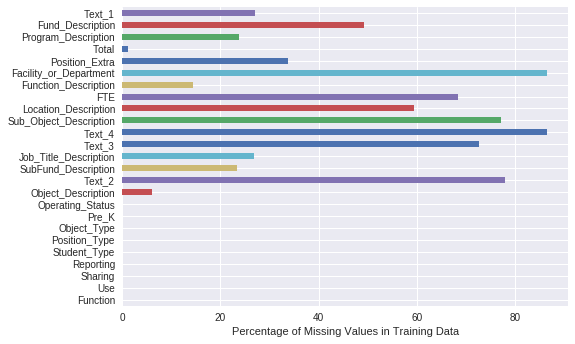

In [0]:
((train.isnull().sum())/train.shape[0]*100).plot(kind='barh')
plt.xlabel('Percentage of Missing Values in Training Data')
plt.show()

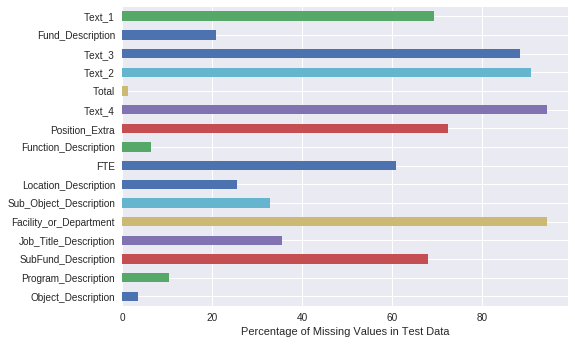

In [0]:
((test.isnull().sum())/test.shape[0]*100).plot(kind='barh')
plt.xlabel('Percentage of Missing Values in Test Data')
plt.show()

The dataset has a lot of missing values that will need to be dealt with - some have as much as 86% missing values. Imputation could be a good candidate method versus simply dropping rows with missing values. So I will make to sure to deal with missing values in the numeric features using the mean/median; the free-form text features will be dealt with by replacing missing values with an empty space.

In [0]:
# datatypes
train.dtypes.value_counts()

object     23
float64     2
dtype: int64

Most of the features are stored as an object type. To make our model more efficient we will cast them to the categorical type.


There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take.  Here are the 9 label columns:

<code>LABELS = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']</code>

In [0]:
LABELS = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

train[LABELS].dtypes

Function            object
Use                 object
Sharing             object
Reporting           object
Student_Type        object
Position_Type       object
Object_Type         object
Pre_K               object
Operating_Status    object
dtype: object

Lets now convert these features into category dtype.

In [0]:
train[LABELS] = train[LABELS].apply(lambda x: x.astype('category'), axis=0)

In [0]:
# verify
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null category
Use                       400277 non-null category
Sharing                   400277 non-null category
Reporting                 400277 non-null category
Student_Type              400277 non-null category
Position_Type             400277 non-null category
Object_Type               400277 non-null category
Pre_K                     400277 non-null category
Operating_Status          400277 non-null category
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non

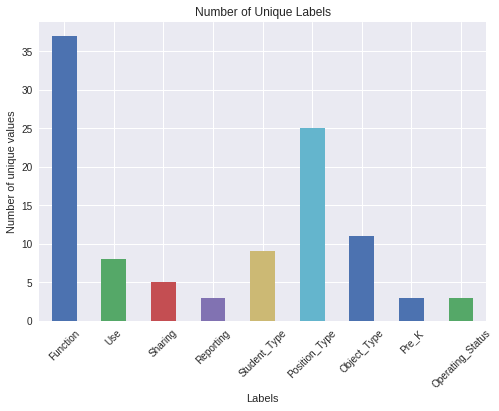

In [0]:
# calculate the number of unique values for each label: num_unique_labels
num_unique_labels = train[LABELS].apply(pd.Series.nunique, axis=0)
num_unique_labels.plot(kind='bar')
plt.title("Number of Unique Labels")
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.xticks(rotation=45)
plt.show()

In [0]:
train[LABELS].describe(include='all')

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
count,400277,400277,400277,400277,400277,400277,400277,400277,400277
unique,37,8,5,3,9,25,11,3,3
top,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating
freq,86354,203608,254433,257258,223026,102788,97670,306425,343578


Most of the budget line items are teacher salaries (Teacher Compensation). The amount of labels varies so I need to make sure that I take this into consideration when developing a model.


# Performance metric

Since there may be a class imbalance, accuracy isn't the best measure of success. Instead, we will use a log loss function to give a heavier penalty to predictions that are wrong and confident. But since we have multiple classes with multiple labels, our performance metric a multiclass version of log loss: multi-multiclass log loss.


Multi-multiclass log loss $= \frac{1}{K}\sum_{k=1}^{K} \left[ - \frac{1}{N} \sum_{n=0}^{N} \sum_{c=1}^{C} y_{k, c, n} \log(\hat{y}_{k, c, n}) \right]$

In [0]:
# log loss cost function manually
def compute_log_loss(predictions, actual, eps=1e-15):
  """
  predictions = float between 0 and 1
  actual = binary value of 0 or 1
  eps = option to offset predictions by eps 
  """
  predicted = np.clip(predictions, eps, 1 - eps)
  loss = - 1 * np.mean(actual * np.log(predicted) + (1-actual) * np.log(1 - predicted))
  
  return loss
  
print(f"Log loss for confident but correct predictions: {compute_log_loss(0.85, 1)}")
print(f"Log loss for confident but incorrect predictions: {compute_log_loss(0.99, 0)}")

Log loss for confident but correct predictions: 0.16251892949777494
Log loss for confident but incorrect predictions: 4.605170185988091


sklearn has a log loss function as well but it isn't compatible for multiclass multilabel problems so we will have to create our own. I will use this [helper function](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/models/metrics.py) made by DrivenData.org to take evaluate the performance of my model.

In [0]:
# indices for each label
BOX_PLOTS_COLUMN_INDICES = [list(range(37)),
                            list(range(37, 48)),
                            list(range(48, 51)),
                            list(range(51, 76)),
                            list(range(76, 79)),
                            list(range(79, 82)),
                            list(range(82, 87)),
                            list(range(87, 96)),
                            list(range(96, 104))]


def multi_multi_log_loss(predicted,
                          actual,
                          class_column_indices=BOX_PLOTS_COLUMN_INDICES,
                          eps=1e-15):
    """ Multi class version of Logarithmic Loss metric as implemented on
        DrivenData.org
    """
    class_scores = np.ones(len(class_column_indices), dtype=np.float64)

    # calculate log loss for each set of columns that belong to a class
    for k, this_class_indices in enumerate(class_column_indices):
        # get just the columns for this class
        preds_k = predicted[:, this_class_indices].astype(np.float64)

        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.inf)

        actual_k = actual[:, this_class_indices]

        # shrink predictions so
        y_hats = np.clip(preds_k, eps, 1 - eps)
        sum_logs = np.sum(actual_k * np.log(y_hats))
        class_scores[k] = (-1.0 / actual.shape[0]) * sum_logs

    return np.average(class_scores)

# use function to make scorer  
from sklearn.metrics.scorer import make_scorer

log_loss_scorer = make_scorer(multi_multi_log_loss)

Now that were familiar with the label distribution and have decided upon a loss function to evaluate our models performance, we need to further explore some of the other features.

In [0]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Function,400277,37,Teacher Compensation,86354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Use,400277,8,Instruction,203608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sharing,400277,5,School Reported,254433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reporting,400277,3,School,257258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Student_Type,400277,9,Unspecified,223026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position_Type,400277,25,Teacher,102788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Object_Type,400277,11,Base Salary/Compensation,97670,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pre_K,400277,3,NO_LABEL,306425,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Operating_Status,400277,3,PreK-12 Operating,343578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Object_Description,375493,602,EMPLOYEE BENEFITS,47495,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is a lot of variance in the total expenditure of the budget line items. Again we see that most common expenditure is related to instruction/teachers. 


# Feature exploration

Lets now explore each of the features to see how we can better clean and engineer them for the model. I'll take a few random samples.

In [0]:
# features that are non-labels
NON_LABELS = [c for c in train.columns if c not in LABELS]
NON_LABELS

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [0]:
train[["Object_Description", "Sub_Object_Description"]].sample(5)

,Object_Description,Sub_Object_Description
129882,SALARIES OF REGULAR EMPLOYEES,NaN
226465,General Supplies,General Supplies
370088,SALARIES OF PART TIME EMPLOYEE,NaN
425113,Capital Outlay,Capital Outlay
308927,Miscellaneous Operating Costs,Fees (Not Associated With Travel)


These two features carry similar meaning. We'll drop Sub_Object_Description.

In [0]:
train[["Job_Title_Description", "Position_Extra"]].sample(5)

,Job_Title_Description,Position_Extra
110918,NaN,NaN
73703,BOOKKEEPER I,NaN
197895,"TRANSPORTATION,BUS DRIVERS,REG",BUS DRIVER
281312,Teacher,PROFESSIONAL-INSTRUCTIONAL
148988,NaN,NaN


In [0]:
train[["Fund_Description", "SubFund_Description"]].sample(5)

,Fund_Description,SubFund_Description
307665,NaN,GENERAL FUND
261293,Title I - Disadvantaged Children/Targeted Assi...,Community Services
227392,NaN,DISTRICT SPECIAL REVENUE FUNDS
269799,General Purpose School,NaN
98259,NaN,FEDERAL GDPG FUND - FY


In [0]:
train["Facility_or_Department"].sample(5)

212708                NaN
119844                NaN
262313    Child Nutrition
94888                 NaN
218382                NaN
Name: Facility_or_Department, dtype: object

In [0]:
train[["Text_1", "Text_2", "Text_3", "Text_4"]].sample(5)

,Text_1,Text_2,Text_3,Text_4
43238,SCHOOL BASED MANAGEMENT,NaN,NaN,NaN
43608,INSTRUCTIONAL STAFF,NaN,Turnaround,NaN
137438,TITLE II D TECH EETT COMP,NaN,NaN,NaN
162709,REGULAR INSTRUCTION,NaN,Regular,NaN
122997,SPECIAL EDUCATION,NaN,Regular,NaN




# Summary thus far

Based off our initial exploration we are going to drop "Text 3" and "Sub Object Description". The rest of the features will be kept for the model.

# Preprocessing the text

Now, lets come up with a strategy to deal with the text values. Since our features our all in seperate columns we need to create a helper function to extract all of the relevant columns, imputes the missing values (encoded as NaN) and combine them into a single string. We can do this by replacing the missing values with a space (" ") and then combining them together using the <code>.join()</code>  string method. The [function](https://github.com/datacamp/course-resources-ml-with-experts-budgets/blob/master/notebooks/1.0-full-model.ipynb) was inspired by pjbull and DataCamp. 

In [0]:
# drop FTE and Total
train_new = train.drop(['Text_3', 'Sub_Object_Description'], axis=1)

In [0]:

mask = (train.dtypes == float)
NUMERIC_COLS = train.columns[mask].tolist()
NUMERIC_COLS

['FTE', 'Total']

In [0]:
train_new.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


In [0]:
# create combine text function
def combine_text_columns(dataframe, to_drop=NUMERIC_COLS + LABELS):
    """ 
    Converts all text in each row into a single vector.
    
    params:
    dataframe = dataframe read in using pandas
    to_drop = all non-text columns and labels (optional)
    
    """
    
    # drop non-text columns and labels
    drop = set(to_drop) & set(dataframe.columns.tolist())
    text_data = dataframe.drop(drop, axis=1)
    
    # replace missing values with blank space
    text_data = text_data.fillna('')
    
    # join all text per row using a space
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [0]:
# verify
text_columns = combine_text_columns(train_new)
text_columns.sample(5)

74499     Salaries And Wages For Substitute Professional...
356625    BOOKS (OTHER THAN TEXTBOOKS) AND PERIODICALS  ...
237218    SALARIES OF PART TIME EMPLOYEE CUSTODIAL-SCHOO...
346595       Teacher-Elementary      5TH GRADE  UPPER EL...
139961              GENERAL EDUCATION LOCAL Teacher        
dtype: object

In [0]:
text_test_columns = combine_text_columns(test)

# Exploring Text Statistics

In [0]:
from textblob import TextBlob
# add statistical features
# make copy
train_text = text_columns.copy()
# make dataframe so that you can create new columns quickly
feats = pd.DataFrame({'text': train_text})
# generate features
feats['word_count'] = feats['text'].apply(lambda x: len(x.split()))
feats['char_count'] = feats['text'].apply(lambda x: len(x.replace(" ", "")))
feats['word_density'] = feats['word_count']/(feats['char_count'] + 1)
feats['sentiment'] = feats['text'].apply(lambda x: TextBlob(x).sentiment[0])


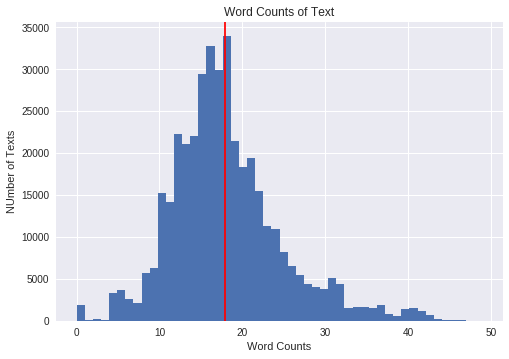

In [0]:
feats['word_count'].hist(bins=50)
plt.title("Word Counts of Text")
plt.axvline(feats['word_count'].mean(), c='r')
plt.xlabel("Word Counts")
plt.ylabel("NUmber of Texts")
plt.show()

In [0]:
feats.word_count.describe()

count    400277.000000
mean         17.963081
std           6.902171
min           0.000000
25%          14.000000
50%          17.000000
75%          21.000000
max          49.000000
Name: word_count, dtype: float64

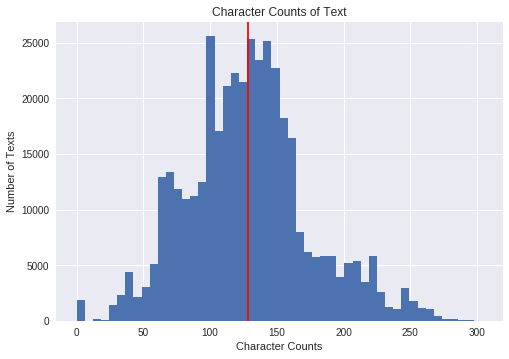

In [0]:
plt.hist(feats['char_count'], bins=50)
plt.title("Character Counts of Text")
plt.axvline(feats['char_count'].mean(), c='r')
plt.xlabel("Character Counts")
plt.ylabel("Number of Texts")
plt.show()

In [0]:
feats.char_count.describe()

count    400277.000000
mean        128.304297
std          46.220369
min           0.000000
25%          99.000000
50%         127.000000
75%         153.000000
max         304.000000
Name: char_count, dtype: float64

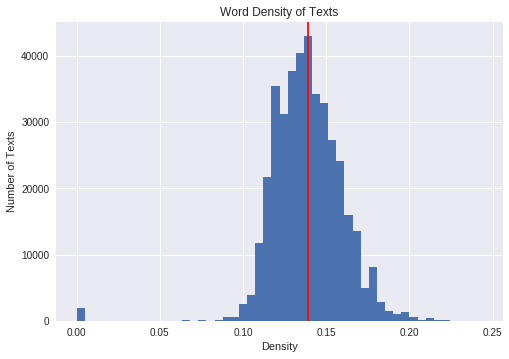

In [0]:
feats['word_density'].hist(bins=50)
plt.title("Word Density of Texts")
plt.axvline(feats['word_density'].mean(), c='r')
plt.xlabel("Density")
plt.ylabel("Number of Texts")
plt.show()

In [0]:
feats.word_density.describe()

count    400277.000000
mean          0.138856
std           0.020972
min           0.000000
25%           0.125000
50%           0.137931
75%           0.151515
max           0.243902
Name: word_density, dtype: float64

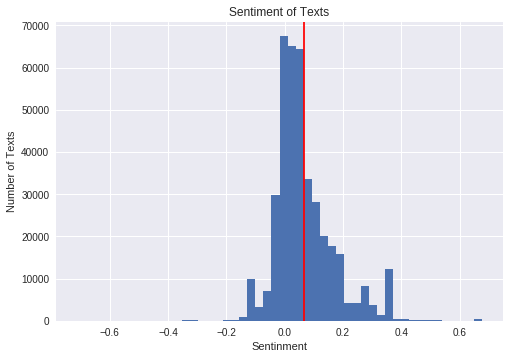

In [0]:
feats['sentiment'].hist(bins=50)
plt.title("Sentiment of Texts")
plt.axvline(feats['sentiment'].mean(), c='r')
plt.xlabel("Sentinment")
plt.ylabel("Number of Texts")
plt.show()

# Visualization with TSNE

In [0]:
############### with preprocessing ###########
# preprocess text
lem = WordNetLemmatizer()
stem = nltk.stem.SnowballStemmer('english')

def preprocess(s):
    s = s.replace( "K-", "K" )
    tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
    tokens = tokenizer.tokenize(s.lower())
    stem_words = [lem.lemmatize(word) for word in tokens]
    return " ".join(stem_words)
  
x_train_processed = text_columns.apply(preprocess)
x_test_processed = text_test_columns.apply(preprocess)

In [0]:
x_train_processed.head()

134338    teacher elementary kindergarten kindergarten g...
206341    contractor service bond expenditure building f...
326408    personal service teacher tcher 2nd grade regul...
364634    employee benefit teacher sub general fund teac...
47683     teacher coverage for teacher teacher sub gener...
dtype: object

In [0]:
# create corpus
corpus = x_train_processed.apply(lambda x: x.split(" "))
corpus.head()

134338    [teacher, elementary, kindergarten, kindergart...
206341    [contractor, service, bond, expenditure, build...
326408    [personal, service, teacher, tcher, 2nd, grade...
364634    [employee, benefit, teacher, sub, general, fun...
47683     [teacher, coverage, for, teacher, teacher, sub...
dtype: object

In [0]:
corpus.shape

(400277,)

In [0]:
# create word embedding
embedding = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200)

# tokens and labels
labels = []
tokens = []

# iterate and append
for word in embedding.wv.vocab:
  tokens.append(embedding[word])
  labels.append(word)
  
# set up tsne model  
tsne_model = TSNE(perplexity=100, n_components=2, init='pca', n_iter=2500, random_state=23)
# transform features
tsne_features = tsne_model.fit_transform(tokens)
# X, y vectors
X, y = [], []
# iterate and append
for i in tsne_features:
  X.append(i[0])
  y.append(i[1])
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


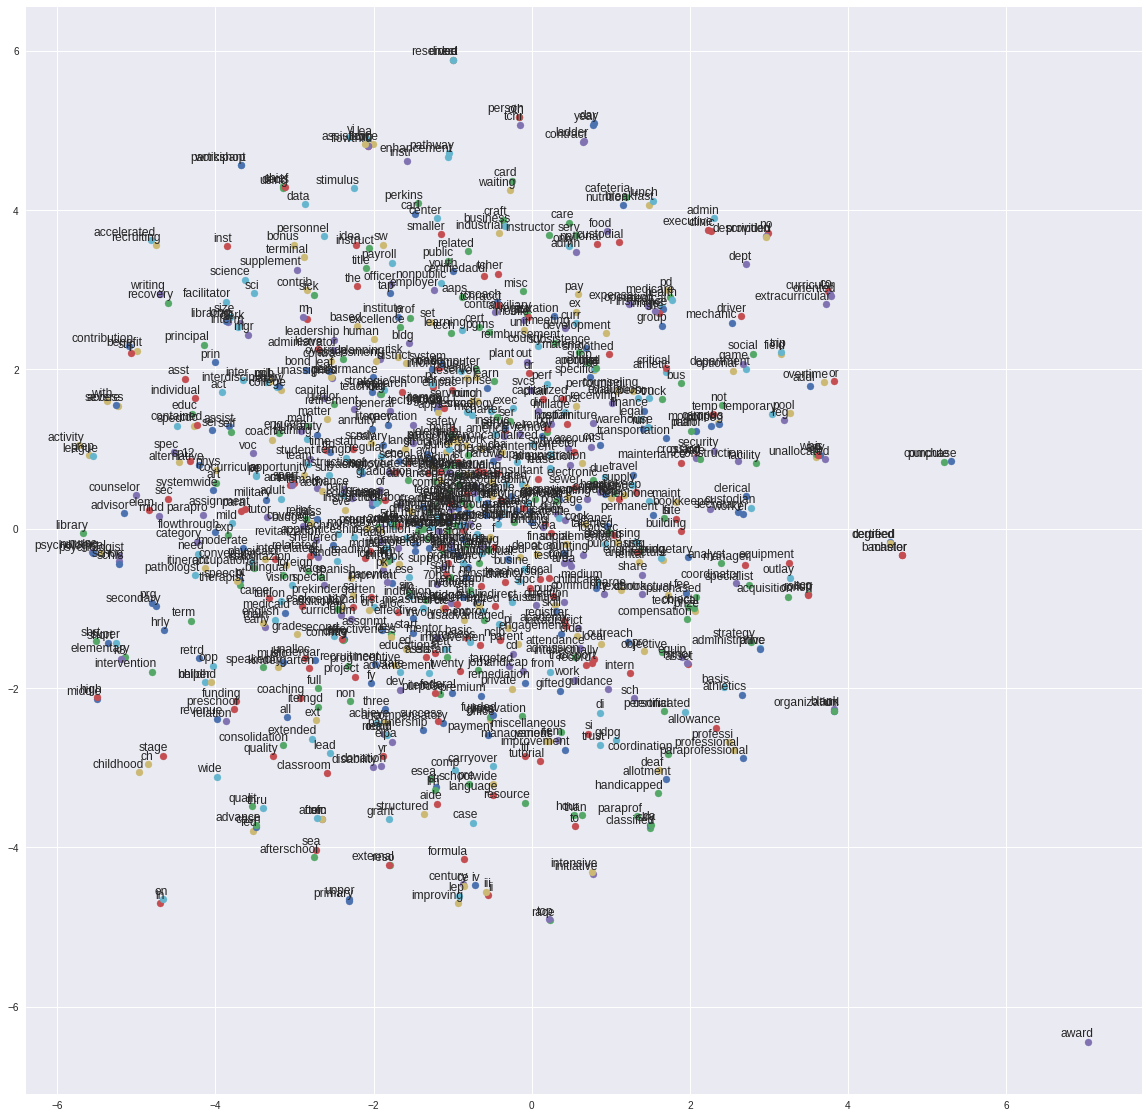

In [0]:
plt.figure(figsize=(20, 20))
for i in range(len(X)):
  plt.scatter(X[i], y[i])
  plt.annotate(labels[i],
              xy=(X[i], y[i]),
              xytext=(5,2),
              textcoords='offset points',
              ha='right',
              va='bottom')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


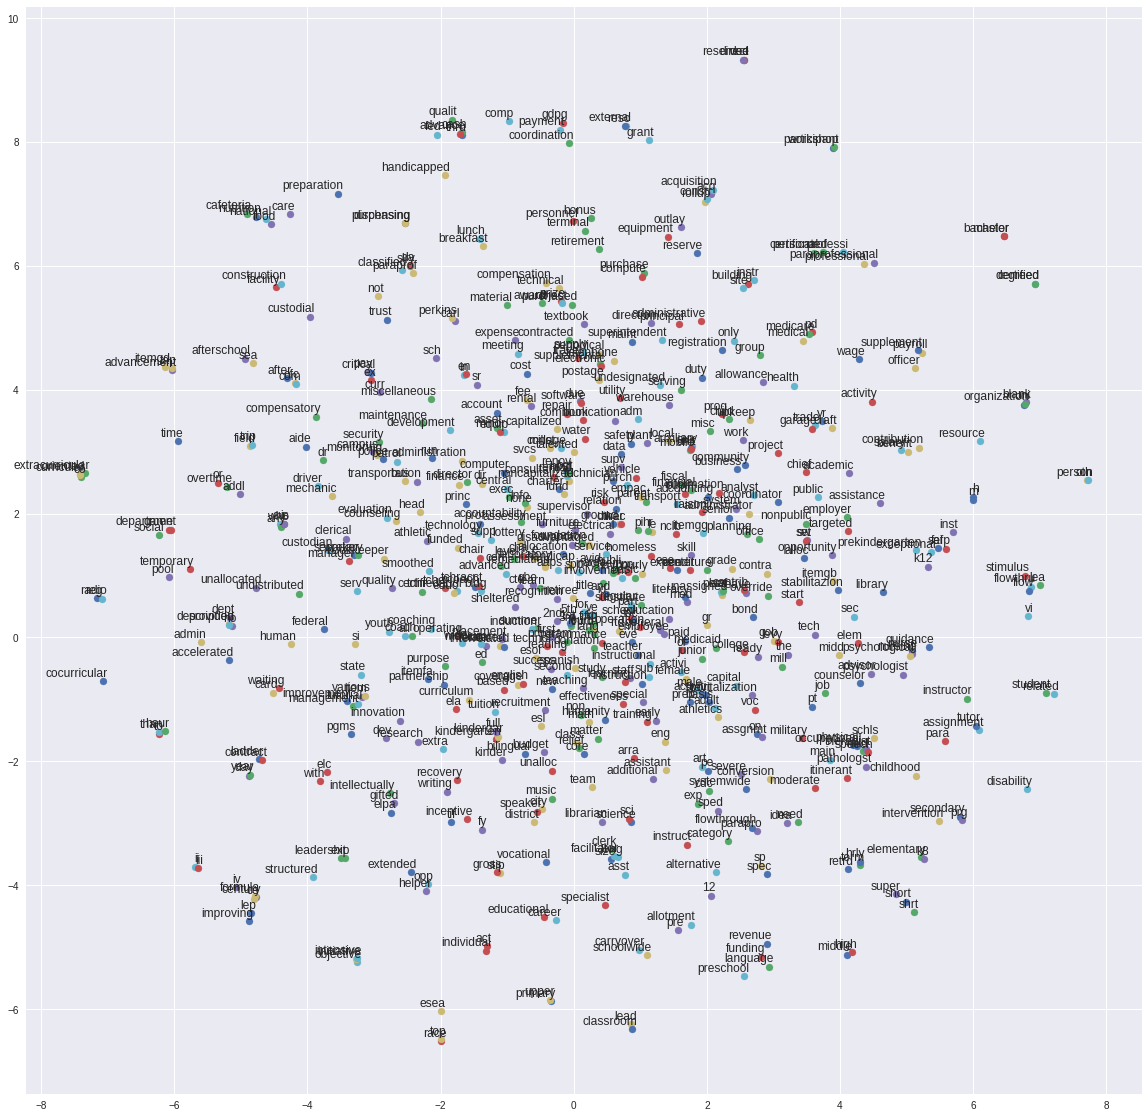

In [0]:
# this time with 500 neighbors
embedding2 = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500)

# tokens and labels
labels = []
tokens = []

# iterate and append
for word in embedding2.wv.vocab:
  tokens.append(embedding2[word])
  labels.append(word)
  
# set up tsne model with smaller perplexity
tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2500, random_state=23)
# transform features
tsne_features = tsne_model.fit_transform(tokens)
# X, y vectors
X, y = [], []
# iterate and append
for i in tsne_features:
  X.append(i[0])
  y.append(i[1])
  
plt.figure(figsize=(20, 20))
for i in range(len(X)):
  plt.scatter(X[i], y[i])
  plt.annotate(labels[i],
              xy=(X[i], y[i]),
              xytext=(5,2),
              textcoords='offset points',
              ha='right',
              va='bottom')
plt.show()

In [0]:
print(tsne_features.shape)

tsne_features

(635, 2)


array([[ 0.97113484, -0.28073463],
       [ 5.2185993 , -3.5462167 ],
       [-1.166476  , -1.6407753 ],
       ...,
       [-0.40241277, -0.14428993],
       [ 4.47001   , -0.5829308 ],
       [-0.8083153 ,  1.5612961 ]], dtype=float32)

In [0]:
embedding.most_similar('teacher')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('instruction', 0.38211575150489807),
 ('instructional', 0.3414516746997833),
 ('counselor', 0.3280782103538513),
 ('rtd', 0.29774463176727295),
 ('esl', 0.2790457308292389),
 ('education', 0.27554041147232056),
 ('custodian', 0.2726908326148987),
 ('principal', 0.2648727595806122),
 ('para', 0.2519032061100006),
 ('regular', 0.24978578090667725)]

In [0]:
embedding2.most_similar('teacher')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('instructional', 0.34116482734680176),
 ('instruction', 0.33274516463279724),
 ('counselor', 0.3145102858543396),
 ('esl', 0.30173438787460327),
 ('specialist', 0.25811824202537537),
 ('principal', 0.2493770271539688),
 ('part', 0.2391573041677475),
 ('humanity', 0.23319850862026215),
 ('education', 0.23284777998924255),
 ('regular', 0.22051870822906494)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


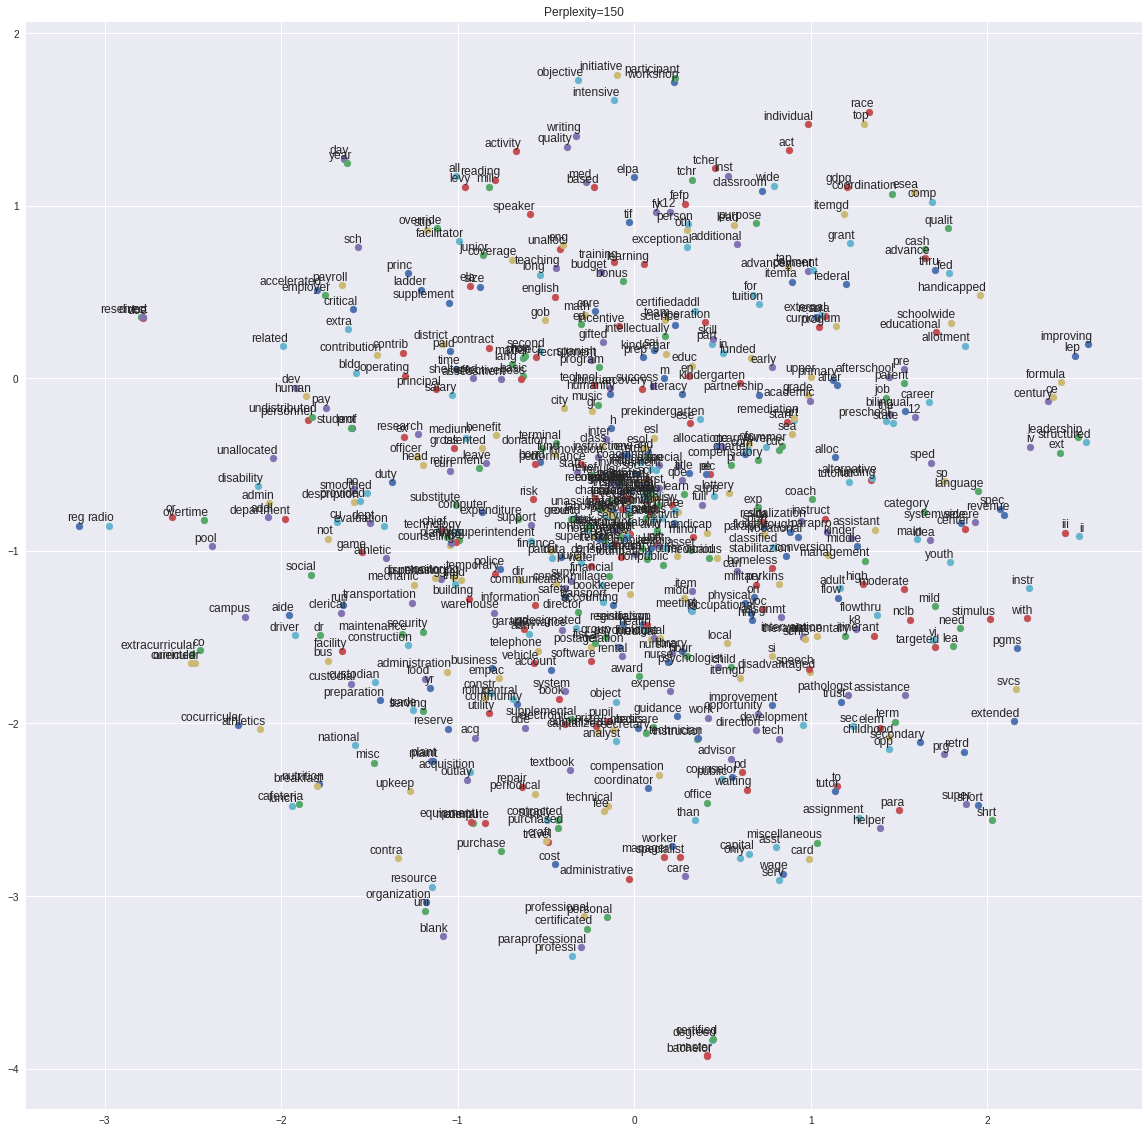

In [0]:
# tokens and labels
labels = []
tokens = []

# iterate and append
for word in embedding2.wv.vocab:
  tokens.append(embedding2[word])
  labels.append(word)
  
# set up tsne model with larger perplexity
tsne_model = TSNE(perplexity=150, n_components=2, init='pca', n_iter=2500, random_state=23)
# transform features
tsne_features = tsne_model.fit_transform(tokens)
# X, y vectors
X, y = [], []
# iterate and append
for i in tsne_features:
  X.append(i[0])
  y.append(i[1])
  
plt.figure(figsize=(20, 20))
for i in range(len(X)):
  plt.scatter(X[i], y[i])
  plt.annotate(labels[i],
              xy=(X[i], y[i]),
              xytext=(5,2),
              textcoords='offset points',
              ha='right',
              va='bottom')
  plt.title("Perplexity=150")
plt.show()

In [0]:
tsne_features.shape

(635, 2)

# Feature Extraction

Now that we have a way to combine the text into a single vector, we need to create a bag of words model.I need to tokenize the features using only alpha-numeric characters. CountVectorizer has a token_pattern parameter that we can use to tokenize the text on punctuation.

We have a couple different options for token patterns: splitting on spaces, or splitting on punctuation. The choice of pattern will change the dimensions of the features so we want to take size into consideration. If the dimensions are really big we will use a HashingVectorizer to help with the computational cost .

In [0]:
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

In [0]:
# basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# text vector
text_vector = combine_text_columns(train_new)

# fit and transform
basic_text = vec_basic.fit_transform(text_vector)


print(f"There are {len(vec_basic.get_feature_names())} tokens in the dataset")


# fit and transform vec_alphanumeric
alphanum_text = vec_alphanumeric.fit_transform(text_vector)


print(f"There are {len(vec_alphanumeric.get_feature_names())} alpha-numeric tokens in the dataset")


There are 4686 tokens in the dataset
There are 3233 alpha-numeric tokens in the dataset


Using the ALPHANUMERIC token pattern, we ended up with 3,233 tokens. This is probably the best choice. But something else I want to try is bigrams. Bigrams will definitely increase the computational cost but it could potentially carry more information and therefore make it worthwhile.

In [0]:
# alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC, 
                                  ngram_range=(1,2))

# text vector
text_vector = combine_text_columns(train_new)

# fit and transform vec_alphanumeric
alphanum_text = vec_alphanumeric.fit_transform(text_vector)

print(f"There are {len(vec_alphanumeric.get_feature_names())} alpha-numeric tokens in the dataset")

There are 29718 alpha-numeric tokens in the dataset


In [0]:
# alphanumeric with trigrams
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC, 
                                  ngram_range=(1,3)) # uni and trigrams

# text vector
text_vector = combine_text_columns(train_new)

# fit and transform vec_alphanumeric
alphanum_text_ngrams = vec_alphanumeric.fit_transform(text_vector)

print(f"There are {len(vec_alphanumeric.get_feature_names())} alpha-numeric tokens in the dataset")

There are 83427 alpha-numeric tokens in the dataset


Using bigrams really blows up the dimension of the features, so to help deal with the computational cost well use the hasing trick. We can implement this using the <code>HashingVectorizer</code> from sklearn.

In [0]:
# alphanumeric
hash_vec = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                     ngram_range=(1,2),
                                     norm=None,
                                     binary=False)

# text vector
text_vector = combine_text_columns(train_new)

# fit and transform vec_alphanumeric
sparse_vec = hash_vec.fit_transform(text_vector)

# Baseline Model:

It's a good idea to get an idea of how much signal we can pull out of the noise, so I'll start off with a simple model to get a baseline score. To make this process faster I'll use a sample from the original dataset.

Well start with a multiclass logistic regression. In order to extend the logistic regression to a multiclass-multilabel problem we need to use a class from sklearn called "OneVsRestClassifier".


# Evaluation Protocol:

StratifiedShuffleSplit is a good example if you have a single target. But since we have 9 target classes, with many different labels, well need create our own utility function to accomplish stratified shuffle splits. The [function](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py) was created by pjbull and DataCamp.


I would like to use Kfold cross validation, but since we are first trying to develop an approach to model this dataset using pipelines, cross validation can be become computationally infeasible. So I will use a holdout set to see how well the model generalizes. 


# Feature preprocessing:

Before we build a baseline model, we need to deal with missing values. I'll use imputation with the mean for the numeric and blank spaces for the text features. I'll also try and reduce the dimensions of the features using a chi-squared test - ill try to find the best 300-500 features. I'll also need to standardize the features after preprocessing, but since I have sparse matrix well want to use a scaler that wont disrupt sparcity. <code> MaxAbsScaler</code>.

To streamline this workflow Im going to use pipelines from <code>sklearn.pipeline</code>. This way we can easily combine the processing and modeling steps and quickly experiment with alternatives by switching some of the steps. While it is a lot of upfront work, the payoff is worth it when you can quickly switch models and preprocessing steps to fine tune the model.

In [0]:
# these functions will sample/split the data into training and validation sets
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
        
        
        Taken from pjbull and DataCamp, link provided above.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])

def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]



def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


In [0]:
# features that are non-labels
NON_LABELS_ = [c for c in train_new.columns if c not in LABELS]
NON_LABELS_

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_4',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']

In [0]:
# one hot encode labels for training set
# full dataset
dummy_labels_train = pd.get_dummies(train_new[LABELS])


# split into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = multilabel_train_test_split(train_new[NON_LABELS_],
                                                               dummy_labels_train,
                                                               0.2,
                                                               min_count=3,
                                                               seed=0)

**Note**: Since this dataset is fairly large (over 400,000 observations) I want to create a sample to develop my approach. This will allow me to experiment a bit quicker. I'll use a10% sample. Using the helper functions I ensure that the sample maintains the class distributions.

In [0]:
# 10% sample
SAMPLE_SIZE = 40000

# one hot encode labels for training set
dummy_labels_train = pd.get_dummies(train_new[LABELS])

# create sample with 10% of data
sample = multilabel_sample_dataframe(train_new,
                                     dummy_labels_train,
                                     size=SAMPLE_SIZE,
                                     min_count=25,
                                     seed=0)
print(f"Sample dimensions {sample.shape}")

# one hot encode sample labels
dummy_labels_sample = pd.get_dummies(sample[LABELS])

# split into training and testing sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(sample[NON_LABELS_],
                                                               dummy_labels_sample,
                                                               0.2,
                                                               min_count=3,
                                                               seed=0)


Sample dimensions (40000, 23)


In [0]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (32000, 14), Test shape: (8000, 14)


In [0]:
print(f"Train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

Train labels shape: (32000, 104), Test labels shape: (8000, 104)


In [0]:
print(f"Train shape: {X_train_full.shape}, Test shape: {X_test_full.shape}")

Train shape: (320222, 14), Test shape: (80055, 14)


In [0]:
print(f"Train labels shape: {y_train_full.shape}, Test labels shape: {y_test_full.shape}")

Train labels shape: (320222, 104), Test labels shape: (80055, 104)


# Building the Pipeline

In order to build a pipeline we have to create our own custom transformers (objects that implement a fit_transform method) so that we can preprocess the text seperately from the numeric features. Well have to join them together using <code>FeatureUnion</code>. Lets build the custom transformers.



We need one transformer to select the text features and another transformer to select the numeric features. There are a couple of ways to do this:

1. Using the FunctionTransformer or
2. Creating your own transformer using TransformerMixin

Well go with the first approach.

In [0]:
# use combine_text_columns to grab text features and combine them
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# use a lambda function to select only numeric columns
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLS], validate=False)

# fit and transform
just_text_data = get_text_data.fit_transform(sample)

# fit and transform
just_numeric_data = get_numeric_data.fit_transform(sample)

In [0]:
# verify
just_text_data.head()

128    Group Health And Life Insurance  Operations   ...
144    PURCHASED PROFESSIONAL AND TECH SVCS-OTHER FEE...
396    EMPLOYER PD MED CONTRIBUTION  GENERAL FUND Lia...
764    EXTRA DUTY PAY-INSTRUCTIONAL     TEACHER, VE  ...
844     GENERAL EDUCATION LOCAL TEACHER,MIDDLE SCHOOL...
dtype: object

In [0]:
# verify
just_numeric_data.head()

,FTE,Total
128,NaN,349.180000
144,NaN,-3856.850000
396,NaN,83.550000
764,NaN,111.080000
844,1.0,68140.339045


We need to also deal with their missing values. We can do this by using the <code>Imputer</code> class  with the numeric features.

Lets now put together a pipeline for text processing and then numeric processing. We will add a model at the end using Logistic Regression

In [0]:
# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None, 
                              binary=False,
                              stop_words='english'))
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer())
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline
pipeline = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('clf', OneVsRestClassifier(LogisticRegression(C=0.001,penalty='l1'))) # l1 regularization
])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# train
pipeline.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline.score(X_test, y_test)}")


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Training accuracy: 0.126375


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.127375


In [0]:
# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 4.604894197352328


I got a baseline accuracy of around 44% and a log loss score of 2.47. This isnt great but its our baseline model and I will improve upon it as the project continues. 

# Adding to the pipeline

I now want to add dimensionality reduction and scaling to the model to see if it increases the score. I also want to include interaction terms so that the tokens interact with each other. For example:


```
A. English teacher for 2nd grade
B. 2nd grade - budget for enlish teacher
```
Because these sentences are basically the same, I want the classifier to recognize both budget items as the same. This is called interaction terms. We can take this into consideration by using this transformer:


```
from sklearn.preprocessing import PolynomialFeatures

interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

interaction.fit_transform(X)
```

The only problem is this class does not work with sparse matrices - which we have. So we need to use a custom class that will allow sparse matrices.



**NLP tricks for data**:

This time ill include unigrams and bi-grams in the model to capture important information like - 'middle school'

All we need to do is adjust our HashingVectorizer object by changing the token pattern and the ngram_range parameter.

```
vec = HashingVectorizer(token_pattern=TOKEN_ALPHANUMERIC,
ngram_range=(1,2))

```

According to the sklearn documentation

**Feature selection with sparse data**

*If you use sparse data (i.e. data represented as sparse matrices), chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense.*



Now I want to add some processing and feature selection to my pipeline. I want to first reduce the number of dimensions of the text features. In order to do this Ill use:


```
from sklearn.feature_selection import chi2, SelectKBest
```

The SelectKBest transformer will apply dimensionality reduction using a chi-squared test, which tests the statistical significance of the features using their observed and expected frequency distributions. I'll then scale the features using:


```
from sklearn.preprocessing import MaxAbsScaler
```

This class scales the features by its maximum absolute value. It doesnt shift/center the data, so it doesnt destroy sparsity - which we have with our bag-of-words text model.

Lets select the best 300 text features ```chi_k=300```.



In [0]:
# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None,
                              binary=False,
                              stop_words='english')),
     ('dim_red', SelectKBest(chi2, 300)) #chi_k = 300
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer(strategy='median'))
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline
pipeline = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(LogisticRegression(penalty='l1',C=0.0001))) # with l1 regularization
])


# train pipeline2
pipeline.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline.score(X_train, y_train)}")

# test accuracy
print(f"Training accuracy: {pipeline.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline, X_test, y_test.values)
print("Log loss score: {}".format(loss))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-p

Training accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Training accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 0.595739037926864


In [0]:
# make a submission to check score using DrivenData.org
predictions = pipeline.predict_proba(test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [0]:
# verify shape
predictions.shape, submission.shape

((50064, 104), (50064, 104))

In [0]:
# store in dataframe
predictions_test = pd.DataFrame(columns=submission.columns,
                             index=submission.index,
                             data=predictions)


# Save prediction_df to csv
predictions_test.to_csv("predictions_test.csv")

# import from notebook
from google.colab import files
files.download("predictions_test.csv")

Our accuracy was 0.0% but our log loss was a lot better! After submitting the test predictions to DrivenData, the score came out to be 2.0477. Its important to note that our custom scorer (multi multi log loss) said our log loss was around 0.59 while DrivenData's scorer said 2.0477. This is probably due to the fact that I trained the model on a 10% sample and tested the model using the full test data. Mind you, this was just a test so moving forward we will make sure to train and test using equivalent datasets.


As for a modeling strategy, it looks like we need to focus on a linear classifier with a decent amount or regularization. Using inspiration from [Cooper Stainbrook](https://github.com/drivendataorg/box-plots-for-education/tree/master/2nd-place/code), I will attempt to use an ensemble of models to make predictions (most likely averaging their probabilities) but I want to first test individual algorithms, looking to see how linear or non-linear classifiers fare on the dataset. 





**Interaction terms**


Since the dataset has some redudant text values (multiple texts that may carry singular meaning) I want to try creating interaction terms as inputs for the model. But this will be computationally expensive, so I may not end up using it the ensemble.

In [0]:
# custom class
class SparseInteractions(BaseEstimator, TransformerMixin):
    """
    Customer transformer to create interaction terms for sparse matrices.
    Created by pjbull and DataCamp.
    """
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)




I'll use SGD to train the classifer for 120 epochs, using elasticnet regularization to reduce the complexity.

In [0]:
# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None,
                              stop_words='english')), 
     ('dim_red', SelectKBest(chi2, 300))
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer(strategy='median'))
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline with sparseinteractions
pipeline = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('int', SparseInteractions()),
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(SGDClassifier(loss='log', penalty='elasticnet', n_iter=120)))
])

# train pipeline
pipeline.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/

Training accuracy: 0.66625


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.648375


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 2.2993442999493467


**Logistic Regression**

In [0]:
# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None,
                              stop_words='english')), 
     ('dim_red', SelectKBest(chi2, 300))
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer(strategy='median'))
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline with sparseinteractions
pipeline = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('int', SparseInteractions()), # this time with interaction terms
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(LogisticRegression(penalty='l1', C=0.0001)))
])

# train pipeline
pipeline.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-p

Training accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 0.595739037926864


So with interactions our accuracy went up but our log loss could be better. We need to try out other models to see if they can better estimate the parameters of the model that reduce the log loss.


Ill try out the following models:


- Random Forests
- SVM: linear and non-linear
- XGBoost, AdaBoost

**Random Forests**

In [0]:
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# text features
x = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(norm=None, 
                              non_negative=True,
                             token_pattern=TOKENS_ALPHANUMERIC,
                             ngram_range=(1,2),
                             stop_words='english')),
    ('dim_red', SelectKBest(chi2, 400)) # chi squared test to reduce dimensions
     ]))

# numeric features
y = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer())
]))

# feature union list
feat_union_list = [x, y]

# build pipeline 
# feature union, sparse interactions, scaler, classifier
pipeline_RF = Pipeline([
    ('union', FeatureUnion(feat_union_list)),
    ('int', SparseInteractions(degree=2)),
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=20)))
])

# fit to training set
pipeline_RF.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pipeline_RF.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

# loss 
loss = log_loss_scorer(pipeline_RF, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWar


Accuracy on budget dataset:  0.75125


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 2.2602843732246996


**XGBoost**

In [0]:

# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None, 
                              binary=False,
                              stop_words='english')),
     ('dim_red', SelectKBest(chi2, 400))
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer()) # using mean this time
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline with random forests
pipeline_XGB = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('int', SparseInteractions()),
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(XGBClassifier(n_estimators=200))) # 200 trees as weak-learners
])

# train pipeline
pipeline_XGB.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline_XGB.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline_XGB.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline_XGB, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWar

Training accuracy: 0.65453125


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.628875


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 2.3506500218012274


**Linear SVC**

In [0]:


# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              non_negative=True, 
                              norm=None, 
                              binary=False)),
     ('dim_red', SelectKBest(chi2, 300))
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer(strategy='mean')) # using mean this time
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline with random forests
pipeline_SVC = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('int', SparseInteractions()),
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(LinearSVC()))
])

# train pipeline
pipeline_SVC.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline_SVC.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline_SVC.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline_SVC, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-pac

Training accuracy: 0.80675


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.735125


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 2.5459682024289036


**SGD Classifier**

In [0]:

# text pipeline
text = ('text', Pipeline([
    ('selector', get_text_data),
    ('vec', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                              ngram_range=(1,2),
                              stop_words='english',
                              non_negative=True, 
                              norm=None, 
                              binary=False)),
     ('dim_red', SelectKBest(chi2, 300))
    
]))

# number pipeline
num = ('numeric', Pipeline([
    ('selector', get_numeric_data),
    ('imp', Imputer())
]))


# create list of pipelines for feature union
pip_list = [text, num]

# building the full pipeline with random forests
pipeline = Pipeline([
    ('union', FeatureUnion(pip_list)),
    ('int', SparseInteractions()), # dim red
    ('scale', MaxAbsScaler()),
    ('clf', OneVsRestClassifier(SGDClassifier(loss='log', penalty='elasticnet', n_iter=120))) # classification with l1 reg
])

# train/backpropagate the pipeline
pipeline.fit(X_train, y_train)

# train accuracy
print(f"Training accuracy: {pipeline.score(X_train, y_train)}")

# test accuracy
print(f"Testing accuracy: {pipeline.score(X_test, y_test)}")

# log loss for multiclass multilabel problem
loss = log_loss_scorer(pipeline, X_test, y_test.values)
print("Log loss score: {}".format(loss))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/

Training accuracy: 0.66409375


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Testing accuracy: 0.645375


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Log loss score: 2.274439583951974


# Summary

As of right now, It looks like a simple logistic regression works best, so I will start with that. I want to avoid overfitting the data so I will use regularization. 

Its now time to test out our approach. I want to train several classifiers using different types of regularization to capture different aspects of the dataset. This is sort of like the story of the blind men and the elephant, each person grabbing different parts of the animal and ultimately coming to different conclusions about what the elephant actually is. The goal is use different models and combine their predictions. So lets now test it out.

**Note: How to submit predictions to DrivenData**

To submit predictions you need to save it as a dataframe (following the submission format from DrivenData) and then score it using the log-loss function.

```
# Generate predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

# Format predictions in dataframe
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv("predictions.csv")


# Print score
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

# Submit the predictions for scoring

```

# Part 2: Emsembling SGD


This part of the notebook will include my primary stategy for the modeling component. 

In [0]:
######################################################
# This will prepare the features for modeling
######################################################


# list of labels
LABELS = ['Function','Object_Type','Operating_Status','Position_Type','Pre_K', 'Reporting',
                'Sharing','Student_Type', 'Use']
# list of features
NON_LABELS = ['FTE','Facility_or_Department', 'Function_Description','Fund_Description',
                       'Job_Title_Description', 'Location_Description','Object_Description',
                       'Position_Extra', 'Program_Description', 'SubFund_Description',
                       'Sub_Object_Description', 'Text_1', 'Text_2','Text_3','Text_4', 'Total']

# train and test features
train_ = train[NON_LABELS]
test_ = test[NON_LABELS]


# drop FTE and Total columns
train_ = train_.drop(['FTE', 'Total'], axis = 1)
test_ = test_.drop(['FTE', 'Total'], axis = 1)


# create a single new column for cleaned text data
# train    
x_train = combine_text_columns(train_)
# test
x_test = combine_text_columns(test_)

# pattern for tokenization
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# initialize TFIDF vectorizer and Hashing Vectorizer
tfidf = TfidfVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                        ngram_range=(1, 2), 
                        max_df=1.0, 
                        min_df=10,
                        stop_words='english') 

# hasing vectorizer with no stop words
hash = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                       stop_words='english')

# fit tfidf and hashing vectorizer to train data
tfidf.fit(x_train)
hash.fit(x_train)

# transform the training and test datasets to obtain a sparse matrix
X_train_tfidf = tfidf.transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

# hash
X_train_hash = hash.transform(x_train)
X_test_hash = hash.transform(x_test)

# training and testing data
X_train = sparse.hstack((X_train_hash, X_train_tfidf))
X_test = sparse.hstack((X_test_hash, X_test_tfidf))

# encode labels
labels = train[LABELS].values
label_encoder = LabelEncoder()
# encode each of the classes individually
for i in range(labels.shape[1]):
  labels[:, i] = label_encoder.fit_transform(labels[:, i])

**Note:**
Credit goes to Abhishek for the tfidf+hashing trick stacked together and the low alpha parameter for the first classifier - although, I was already using the hashing trick, and SGD classifiers prior to viewing his approach and had experimented with ensemble methods. But to be on the safe side (due to MIT licensing), I want to make sure there no infringement or plagiariasm. 

I used a combination of techniques and methods to ultimately develop my approach, and read through a variety of resources. I find it helpful to see what others have done to get a sense of how to tackle a problem. This data science objective, to increase efficiency, and optimize education logistics, is important to me as a working teacher. Budgets make a huge difference in what I am capable of doing and using to educate children. So, when it comes to solving this multi-class, multi-label classification problem, I just wanted to find the best solution.

###Sources: 

**isms**: https://github.com/drivendata/boxplots-for-education-1st-place

**Cooper Stainbrook (Abhishek):** https://github.com/drivendataorg/box-plots-for-education/tree/master/2nd-place/code

**pjbull**: https://github.com/drivendataorg/box-plots-sklearn/tree/master/src

**DataCamp:** 
1. https://www.datacamp.com/courses/machine-learning-with-the-experts-school-budgets
2. Statement of accomplishment: https://www.datacamp.com/statement-of-accomplishment/course/5d23925e2e656e67a6bee8c489ce5424698119ca

# Analytic plan:


The approach is to preprocess the text in two ways.

1. We want to gather all of the text columns into a single vector. I decided to create a function to combine the text, replace missing values with a blank space, then lowercase all of the text.

2. Thanks to [Abhishek](https://github.com/drivendataorg/box-plots-for-education/tree/master/2nd-place/code), I got the idea to create a bag of words first and then stack on top of it (horizontally) a hashing vectorizer. I changed it up by searching for 1,2 grams and tokenizing on punctuation. I also decided to remove the stop words. Bigrams were only included using the weighted tokenizer (Tfidf) because I didnt want to blow up the dimensions too much.

3. As of now, I have not been able to create interaction terms without crashing the notebook, so I will remove them from the model. Later on, I may include them if I can manage.


Now the features are ready for modeling.

In [0]:
# 9 target vectors
labels.shape

(400277, 9)

In [0]:
# training and test dimensions
X_train.shape, X_test.shape

((400277, 1062422), (50064, 1062422))

The modeling approach is as follows:

1. Create 3 regularized classifiers using stochastic gradient descent for each class (9 classes in total). The first model will run for 120-150 epochs with alpha = 0.000005. The second model will use L1 regularization to reduce the complexity of the model. The third model will apply L2 (or elasticnet which was my first try). 27 models are trained.

2. After every model is constructed, make predictions and store them within with a variable. In order to do this on the fly, you can control the flow by setting a condition: when the iteration number is 0, predicted probabilities for each of the three classifiers and then store them within variables. After the first iteration, stack the predictions column wise using the test set.

3. After the models have ran, average the predictions and store them within a dataframe. Export dataframe within notebook using 

```
from google.colab import files
files.download("filename.csv")
```

# Modeling

**Note:** After the first group of SGD classifiers, I experiment with a few other models. The res tof this work will be completed later on the class.



In [0]:
# training and prediction on the the test dataset
##########################################################
# Using SGDClassifier to build 27 models. Each class 
# (9 total) will have 3 models - varying some of the 
# hyperparameters such as:
#    - alpha
#    - penalty
##########################################################

# placeholders
preds1 = []
preds2 = []
preds3 = []

# iterate through the classes and train 3 models
for i in range(labels.shape[1]):
    # display iteration
    print("label = ", i)
    # first classifier with low alpha 0.000001
    sgd1 = SGDClassifier(loss = 'log', n_iter = 150, alpha = 0.000001)
    # second classifier with L1 regularization 
    sgd2 = SGDClassifier(loss = 'log', n_iter = 150, penalty = 'l1')
    # third classifier with elasticnet or L2 regularization
    sgd3 = SGDClassifier(loss = 'log', n_iter = 150, penalty = 'l2')
    sgd1.fit(X_train, labels[:,i].astype(int))
    sgd2.fit(X_train, labels[:,i].astype(int))
    sgd3.fit(X_train, labels[:,i].astype(int))
    # create 3 variables for first iteration
    if i == 0:
        preds1 = sgd1.predict_proba(X_test)
        preds2 = sgd2.predict_proba(X_test)
        preds3 = sgd3.predict_proba(X_test)
    # stack next iterations predictions with the prior iteration (i-1)    
    else:
        preds1 = np.hstack((preds1,sgd1.predict_proba(X_test)))
        preds2 = np.hstack((preds2,sgd2.predict_proba(X_test)))
        preds3 = np.hstack((preds3,sgd3.predict_proba(X_test)))

# take average of predictions
preds_b = (preds1 + preds2 + preds3)/3.0




# format predictions in dataframe
prediction_df_B = pd.DataFrame(columns=submission.columns,
                             index=submission.index,
                             data=preds_b)


# save prediction_df to csv
prediction_df_B.to_csv("predictions_SGD_B2.csv")

label =  0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Predictions were sent to DrivenData for scoring. The score is currently **0.5139** and in 6th place. The goal is to test a few more models and see if there can be further improvements.

In [0]:
from google.colab import files
files.download("predictions_SGD_B.csv")

# AdaBoost

In [0]:
# store predictions   
preds1 = []
preds2 = []
preds3 = []


# iterate through the labels: 9 
for i in range(labels.shape[1]):
   
    
    print("label = ", i)
    # first classifier with low learning rate 0.0001
    ab1 = RandomForestClassifier(n_estimators=100)
    # second classifier with L1 regularization 
    ab2 = AdaBoostClassifier(learning_rate=0.001)
    # third classifier with l1/l2 regularization
    ab3 = AdaBoostClassifier(learning_rate=0.01)
    # fit models, convert labels to integer type
    ab1.fit(X, labels[:,i].astype(int))
    ab2.fit(X, labels[:,i].astype(int))
    ab3.fit(X, labels[:,i].astype(int))
    # for the first iteration, predict probabilities and store inside "preds(n)"
    if i == 0:
        preds1 = ab1.predict_proba(X_test)
        preds2 = ab2.predict_proba(X_test)
        preds3 = ab3.predict_proba(X_test)
    # concatenate the next set of predictions to the preds
    else:
        preds1 = np.hstack((preds1,ab1.predict_proba(X_test)))
        preds2 = np.hstack((preds2,ab2.predict_proba(X_test)))
        preds3 = np.hstack((preds3,ab3.predict_proba(X_test)))

# weighted average of all predictions 
preds = (preds1 + preds2 + preds3)/3.0

preds

label =  0
label =  1
label =  2
label =  3
label =  4
label =  5
label =  6
label =  7
label =  8


array([[0.05671695, 0.00999124, 0.00133474, ..., 0.11749099, 0.06648562,
        0.00205743],
       [0.05671695, 0.00999124, 0.00133474, ..., 0.14508434, 0.07482902,
        0.00185264],
       [0.05671695, 0.00999124, 0.00133474, ..., 0.11749099, 0.06648562,
        0.00205743],
       ...,
       [0.05671695, 0.00999124, 0.00133474, ..., 0.15019335, 0.07729551,
        0.00182325],
       [0.05671695, 0.00999124, 0.00133474, ..., 0.15019335, 0.07729551,
        0.00182325],
       [0.05671695, 0.00999124, 0.00133474, ..., 0.15019335, 0.07729551,
        0.00182325]])

In [0]:
preds.shape

(50064, 104)

In [0]:
# Format predictions in DataFrame: prediction_df
prediction_adaboost = pd.DataFrame(columns=submission.columns,
                             index=submission.index,
                             data=preds)


# Save prediction_df to csv
prediction_adaboost.to_csv("predictions_AdaBoost.csv")

In [0]:
files.download("predictions_AdaBoost.csv")

# SGD with Preprocessing

This time ill try using a different preprocessing method: preprocessing the text by tokenizing, lowercasing, lemmatizing and rejoining.

In [0]:
def preprocess(s):
    s = s.replace( "K-", "K" )
    tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
    tokens = tokenizer.tokenize(s.lower())
    stem_words = [lem.lemmatize(word) for word in tokens]
    return " ".join(stem_words)
  
x_train_processed = x_train.apply(preprocess)
x_test_processed = x_test.apply(preprocess)

In [0]:
################# using processed text ################
# fit tfidf and hashing vectorizer to train data


# initialize TFIDF vectorizer and Hashing Vectorizer
tfidf2 = TfidfVectorizer(
                        ngram_range=(1, 2), 
                        max_df=1.0, 
                        min_df=10,
                        stop_words='english') 

# hasing vectorizer with no stop words and unigrams
hash2 = HashingVectorizer(
                       stop_words='english')

tfidf2.fit(x_train_processed)
hash2.fit(x_train_processed)

# transform the training and test datasets to obtain a sparse matrix
X_train_tfidf2 = tfidf2.transform(x_train_processed)
X_test_tfidf2 = tfidf2.transform(x_test_processed)

# hash
X_train_hash2 = hash2.transform(x_train_processed)
X_test_hash2 = hash2.transform(x_test_processed)

# training and testing data
X_train2 = sparse.hstack((X_train_hash2, X_train_tfidf2))
X_test2 = sparse.hstack((X_test_hash2, X_test_tfidf2))


In [0]:
X_train2.shape, X_test2.shape, labels.shape

((400277, 1062272), (50064, 1062272), (400277, 9))

In [0]:
############################ using preprocessed text #####################
# training and prediction on the the test dataset
##########################################################################
# Using SGDClassifier to build 27 models. Each class 
# (9 total) will have 3 models - varying some of the 
# hyperparameters such as:
#    - alpha
#    - penalty
##########################################################################

# placeholders
preds1 = []
preds2 = []
preds3 = []

# iterate through the classes and train 3 models per class, 27 total models
for i in range(labels.shape[1]):
    print("label = ", i)
    # first classifier with low alpha 0.000001
    sgd1 = SGDClassifier(loss = 'log', n_iter = 150, alpha = 0.000001)
    # second classifier with L1 regularization 
    sgd2 = SGDClassifier(loss = 'log', n_iter = 150, penalty = 'l1')
    # third classifier with elasticnet or L2 regularization
    sgd3 = SGDClassifier(loss = 'log', n_iter = 150, penalty = 'l2')
    sgd1.fit(X_train2, labels[:,i].astype(int))
    sgd2.fit(X_train2, labels[:,i].astype(int))
    sgd3.fit(X_train2, labels[:,i].astype(int))
    # create 3 variables for first iteration
    if i == 0:
        preds1 = sgd1.predict_proba(X_test2)
        preds2 = sgd2.predict_proba(X_test2)
        preds3 = sgd3.predict_proba(X_test2)
    # stack next iterations predictions with the prior iteration (i-1)    
    else:
        preds1 = np.hstack((preds1,sgd1.predict_proba(X_test2)))
        preds2 = np.hstack((preds2,sgd2.predict_proba(X_test2)))
        preds3 = np.hstack((preds3,sgd3.predict_proba(X_test2)))

# take average of predictions
preds_c = (preds1 + preds2 + preds3)/3.0




# format predictions in dataframe
prediction_df_C = pd.DataFrame(columns=submission.columns,
                             index=submission.index,
                             data=preds_c)


# save prediction_df to csv
prediction_df_C.to_csv("predictions_SGD_C.csv")

label =  0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  6


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  7


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


label =  8


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [0]:
from google.colab import files
files.download("predictions_SGD_C.csv")

# XGBoost 

In [0]:
######### xgboost ###############
from sklearn.decomposition import NMF, TruncatedSVD
import xgboost as xgb

# label columns
LABELS = ['Function','Object_Type','Operating_Status','Position_Type','Pre_K', 'Reporting',
                'Sharing','Student_Type', 'Use']
# feature columns
NON_LABELS = ['FTE','Facility_or_Department', 'Function_Description','Fund_Description',
                       'Job_Title_Description', 'Location_Description','Object_Description',
                       'Position_Extra', 'Program_Description', 'SubFund_Description',
                       'Sub_Object_Description', 'Text_1', 'Text_2','Text_3','Text_4', 'Total']

# train and test features for holdout validation
train_ = train[NON_LABELS]
test_ = test[NON_LABELS]

## one hot encode labels for training set
y_train = pd.get_dummies(train_[LABELS])
    

# drop FTE and Total columns
train_ = train_.drop(['FTE', 'Total'], axis = 1)
test_ = test_.drop(['FTE', 'Total'], axis = 1)


# create combine text function
def combine_text_columns(dataframe, to_drop=LABELS):
    """ 
    Converts all text in each row into a single vector.
    
    params:
    dataframe = dataframe read in using pandas
    to_drop = all non-text columns and labels (optional)
    
    """
    
    # drop non-text columns and labels
    drop = set(to_drop) & set(dataframe.columns.tolist())
    text_data = dataframe.drop(drop, axis=1)
    
    # replace missing values with blank space
    text_data = text_data.fillna('')
    
    # join all text per row using a space and lowercase
    return text_data.apply(lambda x: " ".join(x).lower(), axis=1)


# create a single new column for cleaned text data
# train    
train_x_ = combine_text_columns(train_)
# test
test_x_ = combine_text_columns(test_)

# preprocess text
def preprocess(s):
    s = s.replace( "K-", "K" )
    tokenizer = RegexpTokenizer('(?u)\\b\\w\\w+\\b')
    tokens = tokenizer.tokenize(s.lower())
    stem_words = [lem.lemmatize(word) for word in tokens]
    return " ".join(stem_words)
  
x_train_processed = train_x_.apply(preprocess)
x_test_processed = test_x_.apply(preprocess)


# initialize TFIDF + Count Vec
tfidf = TfidfVectorizer(
                        ngram_range=(1, 2), 
                        max_df=1.0, 
                        min_df=10,
                       stop_words='english')

cnt_vec = CountVectorizer(
                         max_df=1.0,
                         min_df=10,
                         stop_words='english')

# fit tfidf and hashing vectorizer to train data
tfidf.fit(x_train_processed)
cnt_vec.fit(x_train_processed)


# transform the training and test datasets to obtain a sparse matrix
X_tfidf = tfidf.transform(x_train_processed)
X_test_tfidf = tfidf.transform(x_test_processed)


X_cnt_vec = cnt_vec.transform(x_train_processed)
X_test_cnt_vec = cnt_vec.transform(x_test_processed)


####################### with dimensionality reduction ############################
# k=500
kbest = SelectKBest(chi2, k=500)

Xt_train = kbest.fit_transform(X_tfidf, y_train.values)
Xt_test = kbest.transform(X_test_tfidf)

Xc_train = kbest.fit_transform(X_cnt_vec, y_train.values)
Xc_test = kbest.transform(X_test_cnt_vec)

# hstack
X_train3 = sparse.hstack((Xt_train, Xc_train))
X_test3 = sparse.hstack((Xt_test, Xc_test))

################### XGBOOST ##################################

b=[0,37,48,51,76,79,82,87,96,104]

pred_prob_test = np.ones((X_test3.shape[0],104))

for i in np.arange(9):
    # print round
    print('Round: '+ str(i+1))
    # slice of labels
    w = b[i+1]-b[i]
    # params
    opt_params = {'booster' : 'gbtree',
              'objective': 'multi:softprob',
              'eval_metric': 'mlogloss',
              'learning_rate': 0.2,
              'n_estimators':1000,
              'colsample_bytree': 0.3,
              'max_depth':5,
              'min_child_weight':32,
              'reg_lambda':1,
              'subsample':0.9,
              'num_class' : w}
    # slice y_train
    y_train_i = y_train.iloc[:,b[i]:b[i+1]].values
    # index with max prob
    y_train_i = np.argmax(y_train_i, axis=1)
    
    # dtrain, dtest                 
    dtrain = xgb.DMatrix(X_train3, label=y_train_i)
    dtest = xgb.DMatrix(X_test3)
                     
    # train 200 epochs             
    model_xgb = xgb.train(opt_params, dtrain, 200)
    # append predictions to pred_prob matrix                 
    pred_prob_test[:,b[i]:b[i+1]] = model_xgb.predict(dtest,ntree_limit=model_xgb.best_ntree_limit).reshape(X_test3.shape[0],w)
    
# format predictions in dataframe
xgb_model = pd.DataFrame(columns=submission.columns,
                             index=submission.index,
                             data=pred_prob_test)
# save csv
xgb_model.to_csv("xgb_predictions.csv")
 

# Ensemble Predictions

Now Ill combine SGD predictions with XGBoost predictions. A weighted average will be used based on their losses from the leaderboard.

In [0]:
# import sgd predictions 
sgd_model = pd.read_csv("predictions_SGD1.csv")

# losses from leaderboard
# L1 is sgdmodel, L2 is xgboost
L_1, L_2 = 0.5139, 0.5976
w_1, w_2 = (1/L_1)/(1/L_1 + 1/L_2), (1/L_2)/(1/L_2 + 1/L_1)

# take weighted average
final_preds = (sgd_model * w_1) + (xgb_model * w_2)